## Inferencia con EfficientDet-D0: Benchmarking de detección de objetos Robocup SSL

Durante este trabajo se tomó como referencia el tutorial de **Roboflow** para el acondicionamiento del dataset y aplicación de la API de [**Object Detection**](https://github.com/tensorflow/models) de TensorFlow:

> Tutorial Roboflow: https://www.youtube.com/watch?v=yJg1FX2goCo

Tanto en el tutorial como en este trabajo se utiliza el modelo **EfficientDet-D0** y en ese sentido las celdas de código utilizadas en este notebook corresponden a las demostradas en el tutorial. En este notebook se presenta los resultados de inferencia graficando las cajas englobantes en objetos detectados a partir del modelo entrenado.

In [1]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import pathlib, os

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

Función de carga de imágenes a arreglos de numpy.

In [2]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

La siguiente celda de código obtiene la función de detección para realizar inferencia a partir del modelo entrenado y se construye a partir del último checkpoint registrado. 

In [5]:
filenames = list(pathlib.Path('training/').glob('*.index'))

filenames.sort()
print(filenames)

# Pipeline configuration file
pipeline_config = 'training/ssd_efficientdet_d0.config'

# Automatically detect the last checkpoint of the training process
model_dir = str(filenames[-1]).replace('.index','')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index','')))

# Model detection function provided by RoboFlow tutorial
def get_model_detection_function(model):
    """Get a tf.function for detection."""

    @tf.function
    def detect_fn(image):
        """Detect objects in image."""

        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)

        return detections, prediction_dict, tf.reshape(shapes, [-1])

    return detect_fn

detect_fn = get_model_detection_function(detection_model)

[PosixPath('training/ckpt-10.index'), PosixPath('training/ckpt-11.index'), PosixPath('training/ckpt-12.index'), PosixPath('training/ckpt-13.index'), PosixPath('training/ckpt-14.index'), PosixPath('training/ckpt-15.index'), PosixPath('training/ckpt-16.index')]


Se obtiene el mapa de labels del dataset SSL.

In [7]:
# Map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

In [10]:
# SSL custom labels
label_map_dict

{'ball': 1, 'goal': 2, 'robot': 3}

La siguiente celda selecciona una imagen aleatoria del directorio del dataset SSL Robocup, incluido en el repositorio de este trabajo, y realiza la tarea de inferencia graficando las cajas englobantes para cada objeto detectado y la probabilidad de pertenencia a la categoría.

../../../ssl-dataset-master/1_resized/00900.jpg


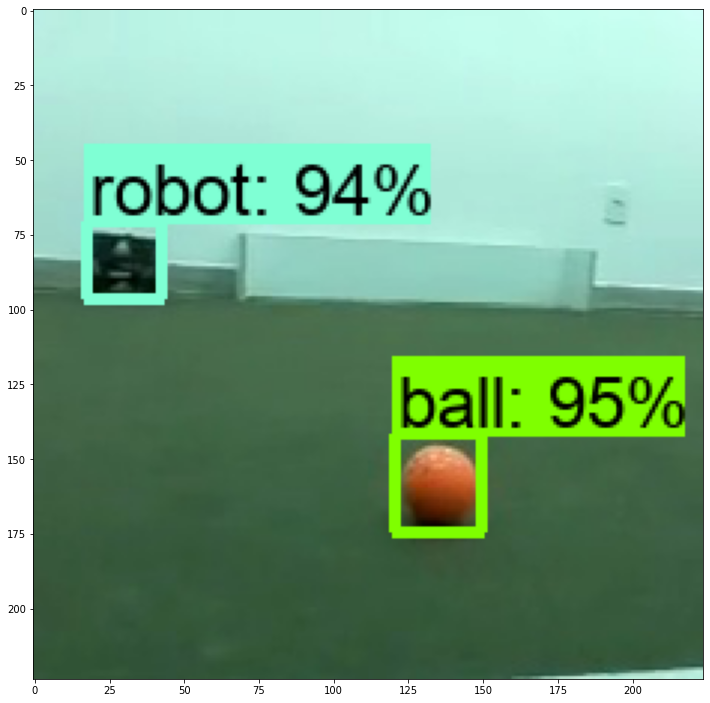

In [35]:
import random, glob

test_image_path = glob.glob('ssl-dataset-master/1_resized/*.jpg')
image_path = random.choice(test_image_path)
image_np = load_image_into_numpy_array(image_path)

print(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()